## Tutorial: Getting started with Emu_mps

In this tutorial, we will show step-by-step how to use Emu_mps to create an antiferromagnetic (AFM) state with a 1D chain of atoms. We will also assess the quality of the final quantum state using the spin-correlation function. The aim of this tutorial is to demonstrate how to use Emu_mps, how to run a sequence, and how to extract important observables such as magnetization, the correlation matrix, fidelity with a given state, and more.

For more information, one can see this [pulser tutorial](https://pulser.readthedocs.io/en/stable/tutorials/afm_prep.html)

In [1]:
import jupyter_black

jupyter_black.load()  # formatting

In [2]:
# import libraries
import matplotlib.pyplot as plt

# emu_mps backend, confing and observables
from emu_mps import (
    MPS,
    MPSConfig,
    MPSBackend,
    StateResult,
    BitStrings,
    Fidelity,
    QubitDensity,
    CorrelationMatrix,
)
from utils_examples.square_perimeter_reg import square_perimeter_points
from utils_examples.afm_state_ring_reg import afm_sequence_from_register

# pulser
import pulser
from pulser.devices import AnalogDevice

import math
import numpy as np

from matplotlib.pyplot import pcolormesh

### Pulser and emp_mps


In general terms, the first step is to generate the pulses with Pulser. Then, instantiate the backend class ( `MPSBackend`) and the BackendConfig (`MPSConfig`) with their respective observables. After this, pass the sequence from Pulser and the config instance to the `run` method. Finally, the user retrieves the observables specified in the config.

We will use Pulser to generate the perimeter of a square with an odd number of atoms and then create the sequence that will yield an antiferromagnetic (AFM) state.

In [3]:
# Pulser setup for AFM state

Omega_max = 2 * 2 * np.pi
U = Omega_max / 2

delta_0 = -6 * U
delta_f = 1 * U

t_rise = 500
t_fall = 1500
sweep_factor = 2  # time for the sweep

R_interatomic = AnalogDevice.rydberg_blockade_radius(U)  # separation between atoms

#### Register creation

The function `square_perimeter_points` will calculate the coordinates of the points located on the perimeter of a square of size L. The points are ordered starting from the bottom-left corner and moving 
    counter-clockwise around the square. The order is important when measuare the bitstrings

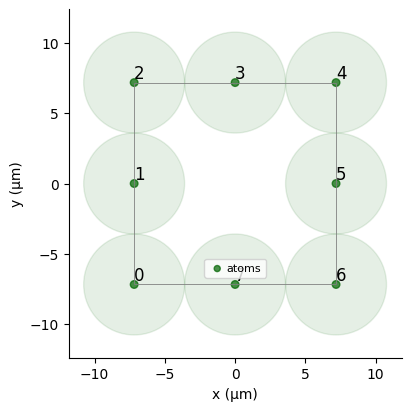

(0, 1, 2, 3, 4, 5, 6, 7)

In [4]:
N_side = 3  # for this tutorial, we choose impair number of atoms and R_interatomic is the units

### we use the interatomic distance R_interatomic as the unit of length.
coords = R_interatomic * square_perimeter_points(N_side)
reg = pulser.Register.from_coordinates(coords)
reg.draw(blockade_radius=R_interatomic, draw_graph=True, draw_half_radius=True)

reg.qubit_ids

### Pulse creation 

The following function `afm_sequence_from_register` gives us the pulses for the AFM state. The sequence consists of three phases: a rise, a sweep, and a fall. The sweep time is given in proportion of rise and fall times. 



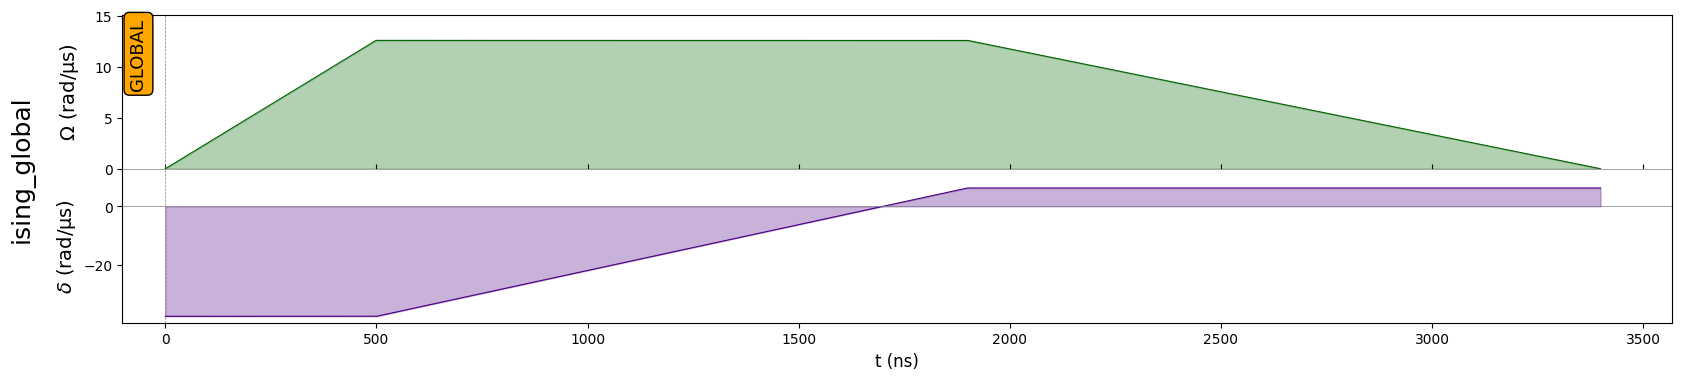

In [5]:
seq = afm_sequence_from_register(
    reg, Omega_max, delta_0, delta_f, t_rise, t_fall, sweep_factor, AnalogDevice
)

seq.draw("input")

### Using Emu-ct

In general, one has to instantiate the backend class and instantiate a config class. The Config class will contain the configuration of the backend and the observables (as callbacks).

In [6]:
seq.register.qubit_ids

(0, 1, 2, 3, 4, 5, 6, 7)

In [7]:
# we initialize a Backend instance
sim = MPSBackend()

In [8]:
# Configuration for the Backend and for observables
dt = 100  # time step for discretization, by the default: dt =10

# information for the observables

final_time = seq.get_duration() // dt * dt
# Calculate the final time of the sequence. Some observables will be measured at time steps
# that are multiples of dt.  Using integer division // ensures time steps align with dt.
# NOTE: The sequence is discretized by dt, so the state evolves at these time steps.

times = [final_time]  # final step for an observable to be measure
# all the times have to be a multiple of dt

times_qubit_density = [
    x for x in range(0, final_time, dt)
]  # a list of time steps for an observable to be measured


# As an example, we are going to create an antiferromagnetic (afm) state (mps) and
# a suporpostion of afm states in order to calculate the
# fidelity against the evolved state

basis = {
    "r",
    "g",
}  # basis that the observables are going to be measured.
# At the moment, we are only accepting the rydberg basis

nqubits = len(seq.register.qubit_ids)  # qubit_ids, for all observables

afm_string_state = {"rgrgrgrg": 1}  # string state as key and amplitud as value |rgrgrgrg>

another_afm = {
    "rg" * int(nqubits / 2): 1.0 / math.sqrt(2),
    "gr" * int(nqubits / 2): 1.0 / math.sqrt(2),
}  # 1/sqrt(2)(|rgrgrgrg>+|grgrgrgr>)

afm_mps_state = MPS.from_state_string(
    basis=basis, nqubits=nqubits, strings=afm_string_state
)
another_afm_mps = MPS.from_state_string(basis=basis, nqubits=nqubits, strings=another_afm)

### Information about the config class in emu_mps


$$\renewcommand{\ket}[1]{\left|{#1}\right\rangle}$$
$$\renewcommand{\bra}[1]{\left\langle{#1}\right|}$$
$$\renewcommand{\braket}[2]{\left\langle{#1}\middle|{#2}\right\rangle}$$

The setting for the config class and information related to observables:

- dt: discretization step of the pulse. In this config instance, we are discretising the sequence each 100 $ns$
- precision: is the truncation presicion of the MPS. We retain singular values greater than the precision value
- observables: we support 
    - StateResult: MPS at a defined time step
    - BitStrings: sampling of the MPS at a de|sired time step
    - Fidelity: $\braket{\psi_{evolved}}{\phi_{given}}$
    - QubitDenisty: magnetization of the state $\langle n_i \rangle = \langle (1+Z_i)/2 \rangle$ which gives the probability that each qubit is in the excited state at a given time step. 
    - CorrelationMatrix: (density correlation matrix) is given by $\langle n_i n_j \rangle =\langle (1+Z_i)/2 * (1+Z_j)/2 \rangle $  at a given time step
    - Energy $\langle H \rangle$ (the ising Hamiltonian) at a given time step
    - Energy Variance: $\langle H^2\rangle - \langle H \rangle^2$ at a given time step

For more information about the observables and updates, one can check the [callbacks code ](https://gitlab.pasqal.com/emulation/rydberg-atoms/emu-ct/-/blob/main/emu_mps/base_classes/callbacks.py?ref_type=heads) in the repository


In [9]:
state_result = StateResult(evaluation_times=times)
bitstrings = BitStrings(evaluation_times=times, num_shots=1000)
fidelity = Fidelity(evaluation_times=times, state=afm_mps_state)  # fidelity number 1
fidelity_another_state = Fidelity(
    evaluation_times=times, state=another_afm_mps
)  # fidelity number 2
density = QubitDensity(evaluation_times=times_qubit_density, basis=basis, nqubits=nqubits)
correlation_matr = CorrelationMatrix(evaluation_times=times, basis=basis, nqubits=nqubits)

In [10]:
# we give the configuration of the backend and the observables
mpsconfig = MPSConfig(
    dt=dt,
    observables=[
        state_result,
        bitstrings,
        fidelity,
        fidelity_another_state,
        density,
        correlation_matr,
    ],
)

### Finally, we run

In order to run the sequence, use the `run` method with the `sequence` and the respective `backend configuration`

In [11]:
results = sim.run(seq, mpsconfig)

step = 1/34, χ = 2, |ψ| = 0.001 MB, RSS = 11.685 MB, Δt = 0.140 s
step = 2/34, χ = 2, |ψ| = 0.001 MB, RSS = 11.685 MB, Δt = 0.137 s
step = 3/34, χ = 3, |ψ| = 0.002 MB, RSS = 11.688 MB, Δt = 0.128 s
step = 4/34, χ = 4, |ψ| = 0.002 MB, RSS = 11.688 MB, Δt = 0.146 s
step = 5/34, χ = 4, |ψ| = 0.002 MB, RSS = 11.688 MB, Δt = 0.143 s
step = 6/34, χ = 5, |ψ| = 0.003 MB, RSS = 11.692 MB, Δt = 0.142 s
step = 7/34, χ = 5, |ψ| = 0.003 MB, RSS = 11.692 MB, Δt = 0.154 s
step = 8/34, χ = 5, |ψ| = 0.003 MB, RSS = 11.693 MB, Δt = 0.146 s
step = 9/34, χ = 5, |ψ| = 0.004 MB, RSS = 11.693 MB, Δt = 0.146 s
step = 10/34, χ = 5, |ψ| = 0.004 MB, RSS = 11.693 MB, Δt = 0.147 s
step = 11/34, χ = 5, |ψ| = 0.004 MB, RSS = 11.693 MB, Δt = 0.148 s
step = 12/34, χ = 6, |ψ| = 0.004 MB, RSS = 11.695 MB, Δt = 0.142 s
step = 13/34, χ = 6, |ψ| = 0.004 MB, RSS = 11.695 MB, Δt = 0.140 s
step = 14/34, χ = 7, |ψ| = 0.005 MB, RSS = 11.696 MB, Δt = 0.142 s
step = 15/34, χ = 8, |ψ| = 0.006 MB, RSS = 11.701 MB, Δt = 0.137 s
step

The information that one can see: 
- step: the whole sequence is discretized by dt and this generates a number of steps. 
- $\chi$ : is the bond dimension
- $|\Psi|$: memory footprint
- RSS: max memory allocation
- $\triangle t$: time that the step took to run


#### How do you get the observables from the results object?

In the following lines, we are going to give a brief code examples of how you can get the information from the results object

In [12]:
# all the observables computed
results.get_result_names()

['qubit_density',
 'state',
 'bitstrings',
 'fidelity_0',
 'fidelity_1',
 'correlation_matrix']

In [13]:
# bitstrings at a given time
bitstrings_final = results[bitstrings.name()][final_time]  # get the bitstring

In [14]:
# show the times when the observables was measured
results.get_result_times(bitstrings.name())

[3400]

In [15]:
max_val = max(bitstrings_final.values())  # max number of counts in the bitstring
print("Max count value: ", max_val)
max_string = [key for key, value in bitstrings_final.items() if value == max_val]
print("Bitstring with the max number of counts: ", max_string)

Max count value:  258
Bitstring with the max number of counts:  ['10101010']


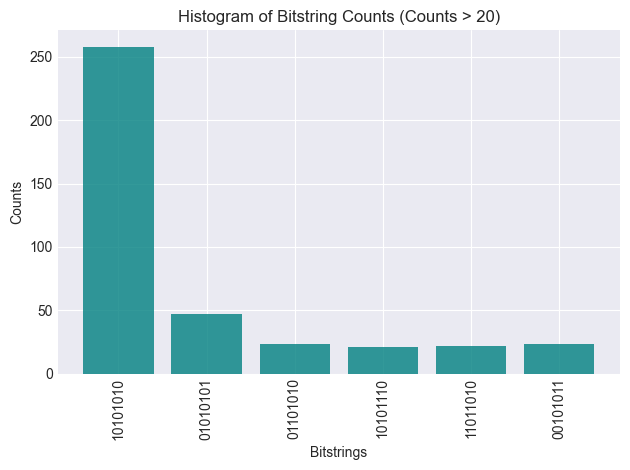

In [16]:
# plot the histogram with counts greater than 20
filtered_counts = [count for count in bitstrings_final.values() if count > 20]
filtered_bitstrings = [
    bitstring for bitstring, count in bitstrings_final.items() if count > 20
]
x_labels = range(len(filtered_bitstrings))


with plt.style.context("seaborn-darkgrid"):
    fig, ax = plt.subplots()
    ax.bar(x_labels, filtered_counts, color="teal", alpha=0.8)
    ax.set_xlabel("Bitstrings")
    ax.set_ylabel("Counts")
    ax.set_title("Histogram of Bitstring Counts (Counts > 20)")
    ax.set_xticks(x_labels)
    ax.set_xticklabels(filtered_bitstrings, rotation="vertical")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    plt.tight_layout()
    plt.savefig("save_bitstring-10.png")
    plt.show()

In [17]:
# final mps information
final_state = results[state_result.name()][final_time]
print("First tensor of the final state")
final_state.factors[0]

First tensor of the final state


tensor([[[-0.2215+0.3995j,  0.1365+0.3495j],
         [-0.1816+0.1259j,  0.0667-0.7729j]]], device='cuda:0',
       dtype=torch.complex128)

In [18]:
# fidelity respect to the final state
final_fidelity = results[fidelity.name()][
    final_time
]  # if you run another time the tutorial will generate another fidelity

print("fidelity between the final state and the afm state given by the user")
print(final_fidelity)

print("\nThe probability of being in the afm state given by the user ")
print(abs(final_fidelity) ** 2)  #  it is related to the bitstrings

fidelity_2 = results[fidelity_another_state.name()][final_time]
print("\nFidelity with superpostions of afm states: ", fidelity_2)
print("\nits probability: ", abs(fidelity_2) ** 2)

fidelity between the final state and the afm state given by the user
(0.48847401176340965-0.12589877857713225j)

The probability of being in the afm state given by the user 
0.2544573626154535

Fidelity with superpostions of afm states:  (0.3167704430217282-0.24607725123677304j)

its probability:  0.16089752714842787


### Evolution of the state in time

In the following lines, we are going to plot the evolution of the magnetization of the state during the given sequence 

In [19]:
# magnetization: it is given by a dictionary where the key is the time step and value is
# the magnetization
magnetization = list(results[density.name()].values())  #

qbitdensity = np.array(magnetization)
timepy = results.get_result_times(density.name())  # list to a numpy array

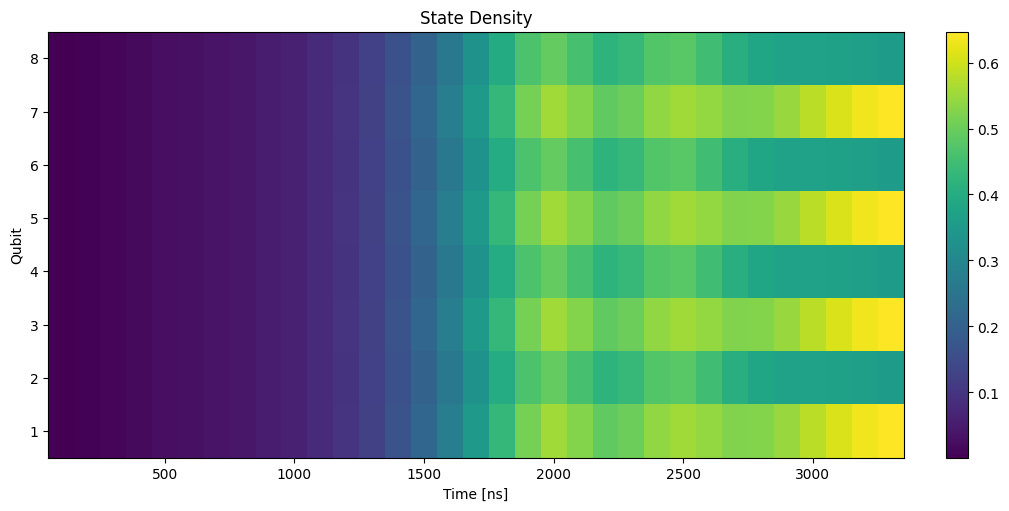

In [20]:
## ploting the heat map
fig, ax = plt.subplots(figsize=(10, 5), layout="constrained")
num_time_points, positions = qbitdensity.shape
x, y = np.meshgrid(np.arange(num_time_points), np.arange(1, positions + 1))
im = pcolormesh(timepy, y, qbitdensity.T, shading="auto")
ax.set_xlabel("Time [ns]")
ax.set_ylabel("Qubit")
ax.set_title("State Density")
ax.set_yticks(np.arange(1, positions + 1))
cb = fig.colorbar(im, ax=ax)

In [21]:
# get the max bond dimension of the final state
max_bond_dim = final_state.get_max_bond_dim()
print("Max bond dimension of the final state: ", max_bond_dim)

Max bond dimension of the final state:  14




### The correlation function at a given time step given by: 

The correlation function given by: 
 $\bra{\psi} n_i(t) n_j(t) \ket{\psi}$

can be extracted from the observables

In [22]:
# the correlation function can be extracted using the following line
final_correlations = np.array(results[correlation_matr.name()][final_time])
final_correlations

array([[0.65056922, 0.09846138, 0.49517966, 0.19347754, 0.45103312,
        0.19348486, 0.49515455, 0.09846857],
       [0.09846138, 0.3517678 , 0.09849875, 0.18672686, 0.19351412,
        0.14633811, 0.19345048, 0.18671352],
       [0.49517966, 0.09849875, 0.65056256, 0.09842712, 0.49514949,
        0.19350774, 0.45107769, 0.19347576],
       [0.19347754, 0.18672686, 0.09842712, 0.3517543 , 0.09845865,
        0.18675435, 0.19345198, 0.1463405 ],
       [0.45103312, 0.19351412, 0.49514949, 0.09845865, 0.65055428,
        0.09848505, 0.49513198, 0.19348052],
       [0.19348486, 0.14633811, 0.19350774, 0.18675435, 0.09848505,
        0.35176938, 0.0985223 , 0.18670057],
       [0.49515455, 0.19345048, 0.45107769, 0.19345198, 0.49513198,
        0.0985223 , 0.65056084, 0.0984262 ],
       [0.09846857, 0.18671352, 0.19347576, 0.1463405 , 0.19348052,
        0.18670057, 0.0984262 , 0.35174253]])

### Assesing our results

We would like to use the correlation function in order to assess our final state. In order to do this we are going to use the spin-spin correlation function, given by

$$g^c(k,l)= \frac{1}{N_{k}}\sum_{(i,j)} \left[ \langle n_i n_j \rangle - \langle n_i \rangle \langle n_j \rangle \right]$$

where the $c$ indicates that we are calculating the *connected* part, and where the sum is over all pairs $(i,j)$ whose distance is $k$.

We are going to construct this function, step by step. 

##### Getting the correlation pairs 
Let's define a function that returns all couples $(i,j)$ of atoms that are separated apart from a given $k$ distance. 

In [23]:
def corr_atoms_pairs(k, N):
    corr_pairs = [[i, (i + k) % N] for i in range(N)]
    return corr_pairs

In [24]:
# correlation function for a given distance k
def k_corr_function(k, N):
    corr_pairs = corr_atoms_pairs(k, N)

    covariance = 0
    for qi, qj in corr_pairs:
        covariance += final_correlations[qi, qj]  # <n_i * n_j>
        covariance -= qbitdensity[-1][qi] * qbitdensity[-1][qj]  # <ni><nj>

    return covariance / len(corr_pairs)

In [25]:
# the spin - spin correlation function
def full_corr_function(reg):
    N = len(reg.qubits)
    correlation_function = {}
    for k in range(-N // 2, N // 2 + 1):
        correlation_function[k] = k_corr_function(k, N)
    return correlation_function

In [26]:
correlation_function = full_corr_function(reg)
correlation_function

{-4: 0.026369149092435595,
 -3: -0.03641080942759732,
 -2: 0.06861066268586993,
 -1: -0.1314226816380346,
 0: 0.2288319028247826,
 1: -0.1314226816380346,
 2: 0.06861066268586995,
 3: -0.03641080942759732,
 4: 0.026369149092435595}

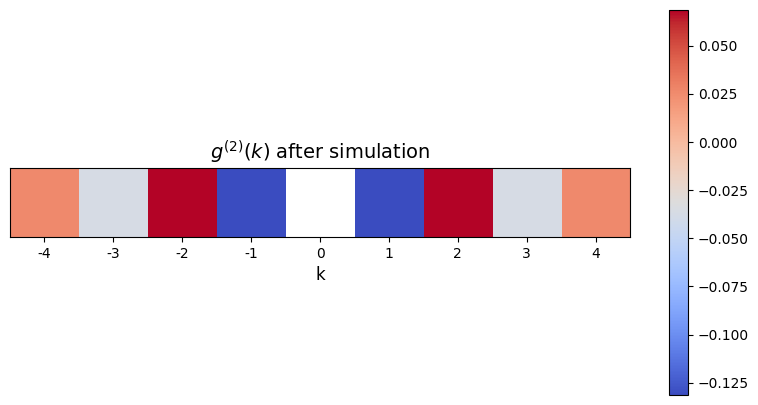

In [27]:
N = len(reg.qubits)
A = np.reshape(list(correlation_function.values()), (1, N + 1))
A[0, N // 2] = None


plt.figure(figsize=(10, 5))
plt.imshow(A, cmap="coolwarm")
plt.xlabel("k", fontsize=12)
plt.xticks(range(A.shape[1]), ["{}".format(i) for i in range(-N // 2, N // 2 + 1)])
plt.title(r"$g^{(2)}(k)$ after simulation", fontsize=14)
plt.yticks([])
plt.colorbar()
plt.show()

In [28]:
# emu_mps version
import emu_mps

emu_mps.__version__

'0.2.0'